<a href="https://colab.research.google.com/github/sarauppal/LSTM_memeText/blob/master/MEMEtextBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
set(stopwords.words('english'))
import re
import string

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
% matplotlib inline

In [0]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
from google.colab import files
uploaded=files.upload()

Saving data_7000_new_manual_clean.csv to data_7000_new_manual_clean.csv


In [0]:
names = ['Image_name','Image_URL','OCR_extracted_text','corrected_text','Humour','Sarcasmoffensive','Motivational','Overall_Sentiment','Basis_of_classification']
df = pd.read_csv("data_7000_new_manual_clean.csv", header=None, names = names)

In [0]:
df.shape

(6600, 9)

In [0]:
df.sample(10)

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasmoffensive,Motivational,Overall_Sentiment,Basis_of_classification
1571,lor_1205bc02902ca2f813dc064f6c68187e.jpeg,https://www.memesmonkey.com/images/memesmonkey...,Then I will die as one of them! Aragorn there ...,Then I will die as one of them! Aragorn there ...,not_funny,not_sarcastic,not_offensive,not_motivational,neutral
90,picard_funny-captain-picard-quotes-best-of-pic...,http://blackdia.net/wp-content/uploads/2018/09...,SACRIFICES PRIME DIRECTIVE TO STOP A WORLD FRO...,SACRIFICES PRIME DIRECTIVE TO STOP A WORLD FRO...,funny,general,hateful_offensive,motivational,negative
872,racis_51IMG_9617.jpg,https://www.facebookjailed.com/wp-content/uplo...,* NOTHING TO SEE HERE ADERA des 208 209RITES d...,* NOTHING TO SEE HERE ADERA des 208 209RITES d...,very_funny,general,very_offensive,motivational,neutral
1639,modi_DedAz8zUwAAvUE9.jpg,https://pbs.twimg.com/media/DedAz8zUwAAvUE9.jpg,When someone decrease the price of petrol by 1...,When someone decrease the price of petrol by 1...,not_funny,not_sarcastic,not_offensive,not_motivational,neutral
892,chandler_its-always-better-to-lie-than-to-have...,https://pics.ballmemes.com/its-always-better-t...,It's always better to lie than to have the com...,It's always better to lie than to have the com...,funny,general,slight,motivational,neutral
4066,got_sub-buzz-21752-1504504371-1.png,https://img.buzzfeed.com/buzzfeed-static/stati...,I can't have children Hold my beer,I can't have children Hold my beer,hilarious,twisted_meaning,hateful_offensive,not_motivational,positive
992,chuck_chuck-norris-threw-a-grenade-and-it-kill...,https://sayingimages.com/wp-content/uploads/ch...,CHUCK NORRIS THREW A GRENADE AND IT KILLED 50 ...,CHUCK NORRIS THREW A GRENADE AND IT KILLED 50 ...,not_funny,general,slight,motivational,neutral
2646,deadpool_65936124e5f81a7b83a23de6f2b6e08f.jpg,https://media0dk-a.akamaihd.net/64/60/65936124...,THAT'S FOR SLAPPING ROBIN SO MUCH! YOU ABUSIVE...,THAT'S FOR SLAPPING ROBIN SO MUCH! YOU ABUSIVE...,very_funny,general,very_offensive,motivational,positive
68,seal_Z7CmFfdZAdf0DcEjQwng2_KygPfLul3290sUA5ssF...,https://external-preview.redd.it/Z7CmFfdZAdf0D...,I DON'T LIKE THOSE AWKWARD SEAL MEMES NA I JUS...,I DON'T LIKE THOSE AWKWARD SEAL MEMES NA I JUS...,very_funny,twisted_meaning,slight,motivational,negative
1476,hillary_dtmeme3.jpg,https://i2.wp.com/www.wehuntedthemammoth.com/w...,I am not afraid of an army of lions led by a c...,I am not afraid of an army of lions led by a c...,not_funny,twisted_meaning,very_offensive,not_motivational,neutral


In [0]:
    def preprocess(text):
   
        #remove everything after time stamp
        text = re.sub(r'((1[0-2]|0?[1-9]):([0-5][0-9]) ?([AaPp][Mm]) ?(-) ([\s\S]+))', '', text)
     
        #remove @mentions with user ID
        text = re.sub(r'@[A-Za-z0-9]+','',text)
     
        # Check characters to see if they are in punctuation
        text = re.sub('\d+','', text)
       #remove punctuation
        
        nopunc = [char for char in text if char not in string.punctuation]
      
        # Join the characters again to form the string.
        combined = ''.join(nopunc)
       
        # convert text to lower-case
        combined = combined.lower()
     
        # remove URLs
        combined = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', combined)
             
        # remove # but keep the hastag as word
        combined = re.sub(r'#([^\s]+)', r'\1', combined)
 
        # combined = [word for word in combined if word not in stopwords.words('english')]
        # print(combined)
        return combined


In [0]:
    def get_index(item_set, unk = None):
        item2id = defaultdict(int)
        if unk is not None:
            item2id[unk] = 0
        for item in item_set:
            item2id[item] = len(item2id)
            
        return item2id    

In [0]:
sentences = df.OCR_extracted_text.values
labels = df.Basis_of_classification.values

#clean sentences

clean_sentences = []
clean_labels = []
sentences_n_labels = np.array(list(zip(sentences,labels)))


In [0]:
for sen, lab in sentences_n_labels:
  if (type(sen) != float):
    clean_sentences.append(preprocess(sen))
    clean_labels.append(lab)


In [0]:
clean_sentences = ["[CLS] " + sentence + " [SEP]" for sentence in clean_sentences]

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 5953822.90B/s]


In [0]:
tokenized_texts=[tokenizer.tokenize(sen) for sen in clean_sentences]

In [0]:
# convert labels to ids
# set of label values
classes = set(clean_labels)

In [0]:
label2id = get_index(classes)

In [0]:
targets = [label2id[label] for label in clean_labels ]

In [0]:
lengths = [len(sen) for sen in tokenized_texts]

median 17.0
mean 18.47
max 225
min 2


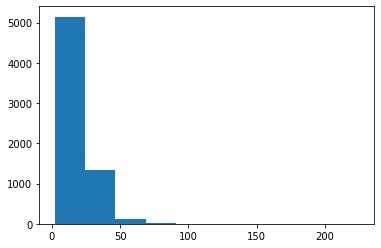

In [0]:
plt.hist(lengths)
print("median",np.median(lengths))
print("mean %.2f"%np.mean(lengths))
print("max",np.max(lengths))
print("min",np.min(lengths))


In [0]:
MAX_LEN=128

In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(tok) for tok in tokenized_texts ]

In [0]:
input_ids = pad_sequences(input_ids, MAX_LEN, dtype="long", padding="post", truncating="post")

In [0]:
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, targets, random_state=2018, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [0]:
batch_size=32

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
train_loss_set = []
epochs = 20



for _ in trange(epochs, desc="Epoch"):
  
  

  model.train()
  

  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  

  for step, batch in enumerate(train_dataloader):
 

    b_input_ids, b_input_mask, b_labels = batch

    optimizer.zero_grad()

    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
 
    loss.backward()

    optimizer.step()
    
    

    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    

  model.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():

      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.2832616856021266



Epoch:   5%|▌         | 1/20 [04:45<1:30:18, 285.21s/it]

Validation Accuracy: 0.4401785714285714
Train loss: 1.2715816658030274



Epoch:  10%|█         | 2/20 [09:30<1:25:35, 285.33s/it]

Validation Accuracy: 0.4401785714285714
Train loss: 1.2494077833109005



Epoch:  15%|█▌        | 3/20 [14:15<1:20:46, 285.09s/it]

Validation Accuracy: 0.3595238095238095
Train loss: 1.0765054136194208



Epoch:  20%|██        | 4/20 [18:58<1:15:52, 284.53s/it]

Validation Accuracy: 0.35267857142857145
Train loss: 0.6778595548483634



Epoch:  25%|██▌       | 5/20 [23:40<1:10:58, 283.88s/it]

Validation Accuracy: 0.39107142857142857
Train loss: 0.383194416521057



Epoch:  30%|███       | 6/20 [28:22<1:06:03, 283.12s/it]

Validation Accuracy: 0.31726190476190474
Train loss: 0.24645885556776037



Epoch:  35%|███▌      | 7/20 [33:05<1:01:21, 283.20s/it]

Validation Accuracy: 0.37410714285714286
Train loss: 0.18144634017540562



Epoch:  40%|████      | 8/20 [37:49<56:41, 283.42s/it]  

Validation Accuracy: 0.38095238095238093
Train loss: 0.15249801457168594



Epoch:  45%|████▌     | 9/20 [42:32<51:57, 283.37s/it]

Validation Accuracy: 0.3372023809523809
Train loss: 0.13160866641149085



Epoch:  50%|█████     | 10/20 [47:16<47:14, 283.43s/it]

Validation Accuracy: 0.35654761904761906
Train loss: 0.11640230235793898



Epoch:  55%|█████▌    | 11/20 [51:59<42:30, 283.43s/it]

Validation Accuracy: 0.36488095238095236
Train loss: 0.10943474584529476



Epoch:  60%|██████    | 12/20 [56:44<37:49, 283.70s/it]

Validation Accuracy: 0.3410714285714286
Train loss: 0.09599872390108724



Epoch:  65%|██████▌   | 13/20 [1:01:28<33:06, 283.85s/it]

Validation Accuracy: 0.36547619047619045
Train loss: 0.0935789318254558



Epoch:  70%|███████   | 14/20 [1:06:12<28:23, 283.99s/it]

Validation Accuracy: 0.3886904761904762
Train loss: 0.09084561249611758



Epoch:  75%|███████▌  | 15/20 [1:10:56<23:39, 283.91s/it]

Validation Accuracy: 0.3669642857142857
Train loss: 0.08849720773036762



Epoch:  80%|████████  | 16/20 [1:15:39<18:54, 283.70s/it]

Validation Accuracy: 0.3461309523809524
Train loss: 0.08347658132032681



Epoch:  85%|████████▌ | 17/20 [1:20:22<14:10, 283.49s/it]

Validation Accuracy: 0.35892857142857143
Train loss: 0.08587893741505762



Epoch:  90%|█████████ | 18/20 [1:25:05<09:26, 283.40s/it]

Validation Accuracy: 0.3857142857142857
Train loss: 0.08399982696339008



Epoch:  95%|█████████▌| 19/20 [1:29:49<04:43, 283.53s/it]

Validation Accuracy: 0.37023809523809526
Train loss: 0.08442550921632398



Epoch: 100%|██████████| 20/20 [1:34:33<00:00, 283.69s/it]


Validation Accuracy: 0.38035714285714284


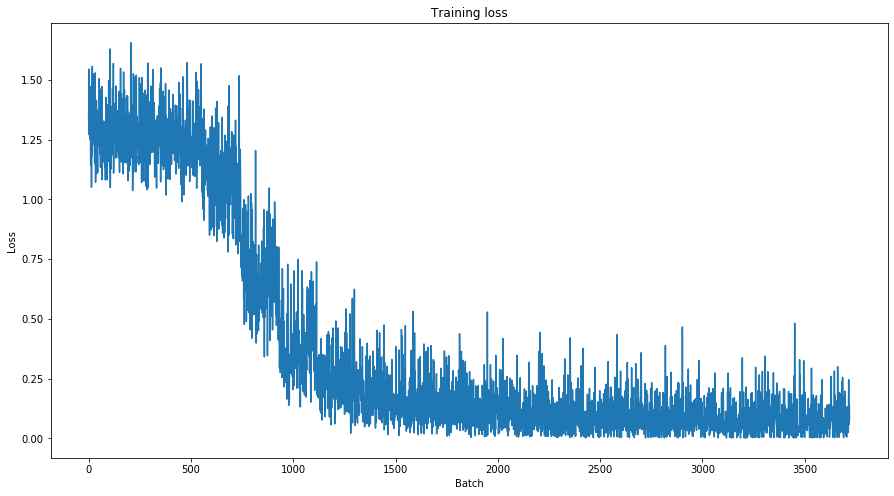

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()